## Convolutional Neural Networks (CNN)

### Example: CIFAR-10 Data (10-Class Classification)  

**CIFAR-10** is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 $32 \times 32$ color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

#### 0. Visualize Raw Data

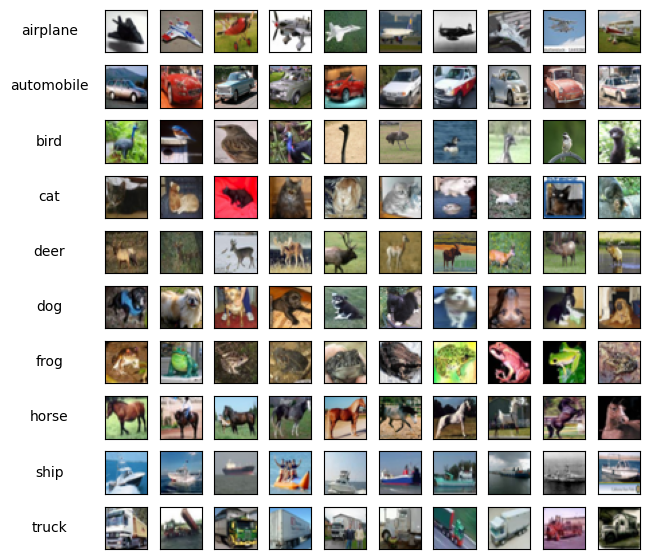

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Load CIFAR-10 (no transforms) to get PIL images
cifar10_train_raw = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)

# 2. Prepare a mapping of class to list of indices (we’ll collect 10 examples per class)
classes = cifar10_train_raw.classes 
#Create an empty dictionary for each of the 10 CIFAR‑10 classes.
class_indices = {i: [] for i in range(10)} 

for idx, (_, label) in enumerate(cifar10_train_raw):
    if len(class_indices[label]) < 10:
        class_indices[label].append(idx)
    if all(len(class_indices[c]) == 10 for c in class_indices):
        break

# 3. Create a 10×10 grid of subplots
fig, axes = plt.subplots(10, 10, figsize=(7, 7))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for row, class_idx in enumerate(range(10)):
    for col in range(10):
        img_idx = class_indices[class_idx][col]
        img, _ = cifar10_train_raw[img_idx]
        ax = axes[row, col]
        ax.imshow(np.array(img))
        ax.set_xticks([])
        ax.set_yticks([])
        # Label the first column of each row with the class name
        if col == 0:
            ax.set_ylabel(classes[class_idx], rotation=0, labelpad=40, va='center', fontsize=10)

plt.show()


#### 1. Load and Preprocess Data

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations for train and test sets.
#    - ToTensor(): converts PIL Image [0,255] → FloatTensor in [0.0,1.0]
#    - Normalize(): applies (x − mean) / std channel‐wise.
#      CIFAR‑10’s per‐channel mean and std (RGB):
#        mean = [0.4914, 0.4822, 0.4465]
#        std  = [0.2470, 0.2435, 0.2616]

transforms = transforms.Compose([
    transforms.ToTensor(),      
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616]
    ),
])

# Download (if needed) and create the CIFAR‑10 training and test datasets.
cifar10_train = datasets.CIFAR10(
    root="./data",            # you can change this to wherever you want to store CIFAR‑10
    train=True,
    transform=transforms,
    download=True
)

cifar10_test = datasets.CIFAR10(
    root="./data",
    train=False,
    transform=transforms,
    download=True
)


# Wrap datasets in DataLoader to handle batching, shuffling, and parallel loading.
BATCH_SIZE = 128

train_loader = DataLoader(
    cifar10_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    cifar10_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [3]:
# How many samples are there? 
len(cifar10_train.data), len(cifar10_train.targets), len(cifar10_test.data), len(cifar10_test.targets)

(50000, 50000, 10000, 10000)

#### 2. Build a CNN model 

I choose to use a simplified version of **AlexNet** (with less parameters) here.

In [4]:
import torch
import torch.nn as nn

class AlexNet_CIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # --------------------------------------------------
        # Feature extractor: 5 convolutional layers + 3 pooling layers
        # --------------------------------------------------
        self.features = nn.Sequential(
            # Conv1: channels (3 -> 32) size (32×32 -> 32×32 -> 16×16)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            # Conv2: channels (32 -> 64) size (16×16 -> 16×16 -> 8×8)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 8×8

            # Conv3: channels (64 -> 128) size (8x8 -> 8x8)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv4: channels (128 -> 256) size (8x8 -> 8x8)
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Conv5: channels (256 -> 256) size (8x8 -> 8x8 -> 4x4)
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

        # --------------------------------------------------
        # Classifier: flatten 256*4*4 -> num_classes
        # --------------------------------------------------
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),                          # First dropout
            nn.Linear(256 * 4 * 4, 2048),               # Fully connected: 256*4*4 -> 2048
            nn.ReLU(inplace=True),

            nn.Dropout(p=0.5),                          # Second dropout
            nn.Linear(2048, 1024),                      # Fully connected: 2048 -> 1024
            nn.ReLU(inplace=True),

            nn.Linear(1024, num_classes)                # Final linear layer: 1024 -> num_classes
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  
        x = self.classifier(x)
        return x
    

#### 3. Training

In [5]:
device = "mps"

In [6]:
### training function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
    train_loss = 0
    model.to(device)
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        model.train()
        output = model(X)
        loss = loss_fn(output, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f}")

### testing function
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() 
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            test_loss += loss_fn(output, y)
            y_pred = torch.argmax(output, dim=1)
            test_acc += (y == y_pred).float().mean()
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")

In [7]:
# Setup loss and optimizer
model_1 = AlexNet_CIFAR(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
from tqdm.auto import tqdm
torch.manual_seed(42)

# Train and test model 
epochs = 30
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device
        )
    
    test_step(data_loader=test_loader,
        model=model_1,
        loss_fn=loss_fn,
        device=device
        )

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.57807
Test loss: 1.22935 | Test accuracy: 0.55

Epoch: 1
---------
Train loss: 1.11691
Test loss: 0.97681 | Test accuracy: 0.65

Epoch: 2
---------
Train loss: 0.91266
Test loss: 0.82349 | Test accuracy: 0.71

Epoch: 3
---------
Train loss: 0.78227
Test loss: 0.76274 | Test accuracy: 0.74

Epoch: 4
---------
Train loss: 0.68502
Test loss: 0.72235 | Test accuracy: 0.76

Epoch: 5
---------
Train loss: 0.61580
Test loss: 0.71003 | Test accuracy: 0.75

Epoch: 6
---------
Train loss: 0.54637
Test loss: 0.69736 | Test accuracy: 0.76

Epoch: 7
---------
Train loss: 0.49664
Test loss: 0.67278 | Test accuracy: 0.78

Epoch: 8
---------
Train loss: 0.45101
Test loss: 0.66207 | Test accuracy: 0.78

Epoch: 9
---------
Train loss: 0.41974
Test loss: 0.68627 | Test accuracy: 0.78

Epoch: 10
---------
Train loss: 0.38136
Test loss: 0.65932 | Test accuracy: 0.79

Epoch: 11
---------
Train loss: 0.35597
Test loss: 0.68742 | Test accuracy: 0.78

Epoch: 12
---------
Train 

#### 4. Evaluation and Saving

In [9]:
# evaluation

test_step(data_loader=test_loader,
        model=model_1,
        loss_fn=loss_fn,
        device=device
        )

Test loss: 0.82270 | Test accuracy: 0.79



In [10]:
# Save model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "03_CIFAR_AlexNet.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models/03_CIFAR_AlexNet.pth
